In [259]:
from os import walk

import joblib
import pandas as pd
import datetime
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

In [260]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

In [261]:
def get_test_train_data(sort):
    filenames = next(walk(BASE_FOLDER), (None, None, []))[2]
    print(filenames)

    train_df, test_df = pd.DataFrame(), pd.DataFrame()
    if len(filenames) == 2:
        train_df = pd.read_csv(filepath_or_buffer=BASE_FOLDER + filenames[0], sep=",")
        test_df = pd.read_csv(filepath_or_buffer=BASE_FOLDER + filenames[1], sep=",")
    elif len(filenames) > 2:
        test_df = pd.read_csv(filepath_or_buffer=BASE_FOLDER + filenames[len(filenames) - 1], sep=",")
        test_df = convert_and_sort_time(test_df, sort)

        train_df = pd.DataFrame()
        for i in range(len(filenames) - 1):
            df_temp = pd.read_csv(filepath_or_buffer=BASE_FOLDER + filenames[i], sep=",")
            df_temp = convert_and_sort_time(df_temp, sort)
            train_df = pd.concat([train_df, pd.DataFrame.from_records(df_temp)])

    return train_df, test_df

In [262]:
def convert_and_sort_time(df, sort):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['timestamp'] = [i.replace(tzinfo=datetime.timezone.utc) for i in df['timestamp']]
    if sort:
        df = df.sort_values(by='timestamp', ascending=True)
    return df

In [263]:
def prepare_model_data(df):
    df = df[df['topics_ids'] != -1].copy()
    df['popularity'] = [0 if retweets == 0 else 1 for retweets in df['retweet_count']]
    return df

In [264]:
def split_data(train_df, test_df):
    X_train = train_df.drop('popularity', axis=1)
    y_train = train_df['popularity']
    print(X_train.shape)
    print(y_train.shape)
    X_test = test_df.drop('popularity', axis=1)
    y_test = test_df['popularity']
    print(X_test.shape)
    print(y_test.shape)
    return X_train, y_train, X_test, y_test

In [265]:
BASE_FOLDER = "../../data/processed_tweets/"

num_vars = ['followers', 'following', 'tweet_count', 'seniority']
cat_vars = ['topics_ids', 'sentiment_enc', 'hashtags_enc', 'verified_enc', 'day_phase_enc', 'day_of_week_enc', 'month_enc']

variables_to_predict = ['followers', 'following', 'tweet_count', 'seniority', 'verified_enc', 'day_phase_enc', 'day_of_week_enc', 'month_enc', 'topics_ids', 'sentiment_enc', 'hashtags_enc']

In [266]:
train_df, test_df = get_test_train_data(False)

['tweets_2019.csv', 'tweets_2020.csv', 'tweets_2021.csv']


In [267]:
train_df = prepare_model_data(train_df)
test_df = prepare_model_data(test_df)

In [268]:
X_train, y_train, X_test, y_test = split_data(train_df, test_df)

(383207, 34)
(383207,)
(174108, 34)
(174108,)


## Standardization

In [269]:
X_train_cats = X_train[cat_vars]
scaler = StandardScaler().fit(X_train[num_vars])
X_train_num_scaled = scaler.transform(X_train[num_vars])
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=X_train[num_vars].columns).set_index(X_train.index)

X_test_num_scaled = scaler.transform(X_test[num_vars])
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=X_test[num_vars].columns).set_index(X_test.index)

## Feature Selection

In [270]:
num_feat_to_keep = pd.DataFrame(index=X_train_cats.columns)
cat_feat_to_keep = pd.DataFrame(index=X_train_num_scaled.columns)

In [271]:
def add_feature_selection_res(df_res, features_to_keep, name):
    df_res[name] = 'Discard'
    for var in features_to_keep:
        df_res.loc[var, name] = 'Keep'

### Categorical variables selection

#### Chi-square

In [272]:
def chi_analysis(num_feat_to_keep, X_train, y_train):
    chi2_features = SelectKBest(chi2, k=6)
    chi2_features.fit_transform(X_train, y_train)
    features_to_keep = chi2_features.get_feature_names_out()
    add_feature_selection_res(num_feat_to_keep, features_to_keep, 'Chi2')

In [273]:
chi_analysis(cat_feat_to_keep, X_train_cats, y_train)

### Numerical variables selection

#### ANOVA

In [274]:
def anova_analysis(num_feat_to_keep, X_train, y_train):
    fvalue_selector = SelectKBest(f_classif, k=3)
    fvalue_selector.fit_transform(X_train, y_train)
    features_to_keep = X_train.columns[fvalue_selector.get_support(indices=True)].to_list()
    add_feature_selection_res(num_feat_to_keep, features_to_keep, 'ANOVA')

In [275]:
anova_analysis(num_feat_to_keep, X_train_num_scaled, y_train)

#### Tree-based

In [276]:
def tree_analysis(num_feat_to_keep, X_train, y_train):
    clf = ExtraTreesClassifier(n_estimators=50)
    clf = clf.fit(X_train, y_train)
    features_to_keep = pd.Series(clf.feature_importances_, index=X_train.columns).nlargest(3).index
    add_feature_selection_res(num_feat_to_keep, features_to_keep, 'Trees')

In [277]:
tree_analysis(num_feat_to_keep, X_train_num_scaled, y_train)

#### LASSO Regression

In [278]:
def lasso_analysis(num_feat_to_keep, X_train, y_train):
    reg = LassoCV()
    reg.fit(X_train, y_train)
    coef = pd.Series(abs(reg.coef_), index=X_train.columns)  #Check the coefficients associated with each of the variables
    features_to_keep = coef.nlargest(3).index
    add_feature_selection_res(num_feat_to_keep, features_to_keep, 'Lasso Regression')

In [279]:
lasso_analysis(num_feat_to_keep, X_train_num_scaled, y_train)

#### Recursive Feature Elimination

In [280]:
def rfe_analysis(num_feat_to_keep, X_train, y_train):
    rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=3)
    rfe.fit(X_train, y_train)
    features_to_keep = X_train.columns[rfe.support_]
    add_feature_selection_res(num_feat_to_keep, features_to_keep, 'RFE')

In [281]:
rfe_analysis(num_feat_to_keep, X_train_num_scaled, y_train)

### Final variables

In [282]:
num_feat_to_keep['Discard Nr'] = num_feat_to_keep.apply(lambda x: x.str.findall('Discard').str.len()).sum(axis = 1).astype(int)
num_feat_to_keep

,ANOVA,Trees,Lasso Regression,RFE,Discard Nr
followers,Keep,Keep,Keep,Keep,0
following,Keep,Keep,Discard,Keep,1
tweet_count,Discard,Keep,Keep,Keep,1
seniority,Keep,Discard,Keep,Discard,2


In [283]:
cat_feat_to_keep['Discard Nr'] = cat_feat_to_keep.apply(lambda x: x.str.findall('Discard').str.len()).sum(axis = 1).astype(int)

In [284]:
cat_to_keep = cat_feat_to_keep[cat_feat_to_keep['Discard Nr'] < 1].index.tolist()
num_to_keep = num_feat_to_keep[num_feat_to_keep['Discard Nr'] < 2].index.to_list()
print(cat_to_keep + num_to_keep)

In [285]:
X_train = X_train[cat_to_keep].copy()
X_train[num_to_keep] = X_train_num_scaled[num_to_keep]

In [286]:
X_test = X_test[cat_to_keep].copy()
X_test[num_to_keep] = X_test_num_scaled[num_to_keep]

## Balacing the dataset

### SMOTE Method

In [287]:
print("Before over sampling: ", Counter(y_train))
over_sample = SMOTE(random_state=7)
X_train_over, y_train_over = over_sample.fit_resample(X_train, y_train)
print("After over sampling: ", Counter(y_train_over))

Before over sampling:  Counter({0: 322530, 1: 60677})
After over sampling:  Counter({1: 322530, 0: 322530})


## Models

In [288]:
def compare_base_models(models, X_train, y_train, scoring, num_folds):
    results = []
    results_means = []
    names = []
    df_res = pd.DataFrame(columns=['model', 'score_accuracy'])
    for name, model in models:
        kfold = KFold(n_splits=num_folds)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

        for res in cv_results:
            df_res.loc[len(df_res.index)] = [name, res]

        results.append(cv_results)
        results_means.append(cv_results.mean())
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

    index_min = max(range(len(results_means)), key=results_means.__getitem__)
    return models[index_min]

In [289]:
def algorithm_comparison_chart(title, models_names, results):
    fig = plt.figure()
    fig.suptitle(title)
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(models_names)
    plt.figure(figsize=(16, 9))
    plt.show()

C:\Users\Miguel\PycharmProjects\maleOrFemaleEyes\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Miguel\PycharmProjects\maleOrFemaleEyes\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

LR: 0.263783 (0.084296)
LDA: 0.204359 (0.059215)
CART: 0.587285 (0.014152)
NB: 0.540688 (0.305546)
AB: 0.452401 (0.073017)
GBM: 0.472556 (0.050840)
RFC: 0.632178 (0.013794)
ET: 0.711731 (0.024027)


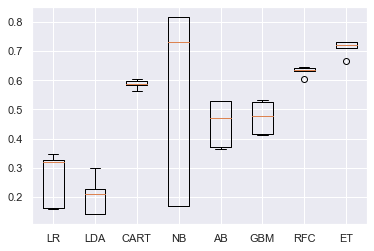

<Figure size 1152x648 with 0 Axes>

In [290]:
models = [('LR', LogisticRegression(solver='lbfgs')), ('LDA', LinearDiscriminantAnalysis()), ('CART', DecisionTreeClassifier()), ('NB', GaussianNB()),
          ('AB', AdaBoostClassifier()), ('GBM', GradientBoostingClassifier()), ('RFC', RandomForestClassifier(n_estimators=100)), ('ET', ExtraTreesClassifier())]
num_folds = 5
seed = 7
scoring = 'accuracy'
res, results, names = compare_base_models(models, X_train_over, y_train_over, scoring, num_folds)
algorithm_comparison_chart("", names, results)

## Hyperparameter Optimization

In [296]:
def find_best_params(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_result = grid_search.fit(X_train, y_train)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [298]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80],
    'max_features': [2],
    'min_samples_leaf': [3],
    'min_samples_split': [8],
    'n_estimators': [100, 200]
}
model = RandomForestClassifier()
find_best_params(model, param_grid, X_train_over, y_train_over)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best: 0.749239 using {'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}


## Test final model

In [293]:
def train_evaluate_save(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print('Model Performance')
    print('Accuracy: {:0.2f}%'.format(accuracy))
    joblib.dump(model, '../../data/models/popularity.joblib')
    return accuracy

In [294]:
model_optimized = RandomForestClassifier(bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100)
train_evaluate_save(model_optimized, X_train_over, y_train_over, X_test, y_test)

Model Performance
Accuracy: 0.72%


0.7181060031704459

In [295]:
popularity_model = joblib.load('../../data/models/popularity.joblib')
predictions = popularity_model.predict(X_test)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.7181060031704459
[[109240  36055]
 [ 13025  15788]]
              precision    recall  f1-score   support

           0       0.89      0.75      0.82    145295
           1       0.30      0.55      0.39     28813

    accuracy                           0.72    174108
   macro avg       0.60      0.65      0.60    174108
weighted avg       0.80      0.72      0.75    174108

